In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nipunarora8/age-gender-and-ethnicity-face-data-csv")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/age-gender-and-ethnicity-face-data-csv


In [2]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.nn import functional as F
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2

In [3]:
os.listdir('/kaggle/input/age-gender-and-ethnicity-face-data-csv')

['age_gender.csv']

In [4]:
df = pd.read_csv('/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv')
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [5]:
df.shape

(23705, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [7]:
df.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
X = df["pixels"]

X = X.apply(lambda x: np.array(list(map(int, x.split(' '))), dtype=np.int32))

X = np.stack(X, axis=0)

X = X.reshape(-1, 48, 48, 1)

print("X shape:", X.shape)

X shape: (23705, 48, 48, 1)


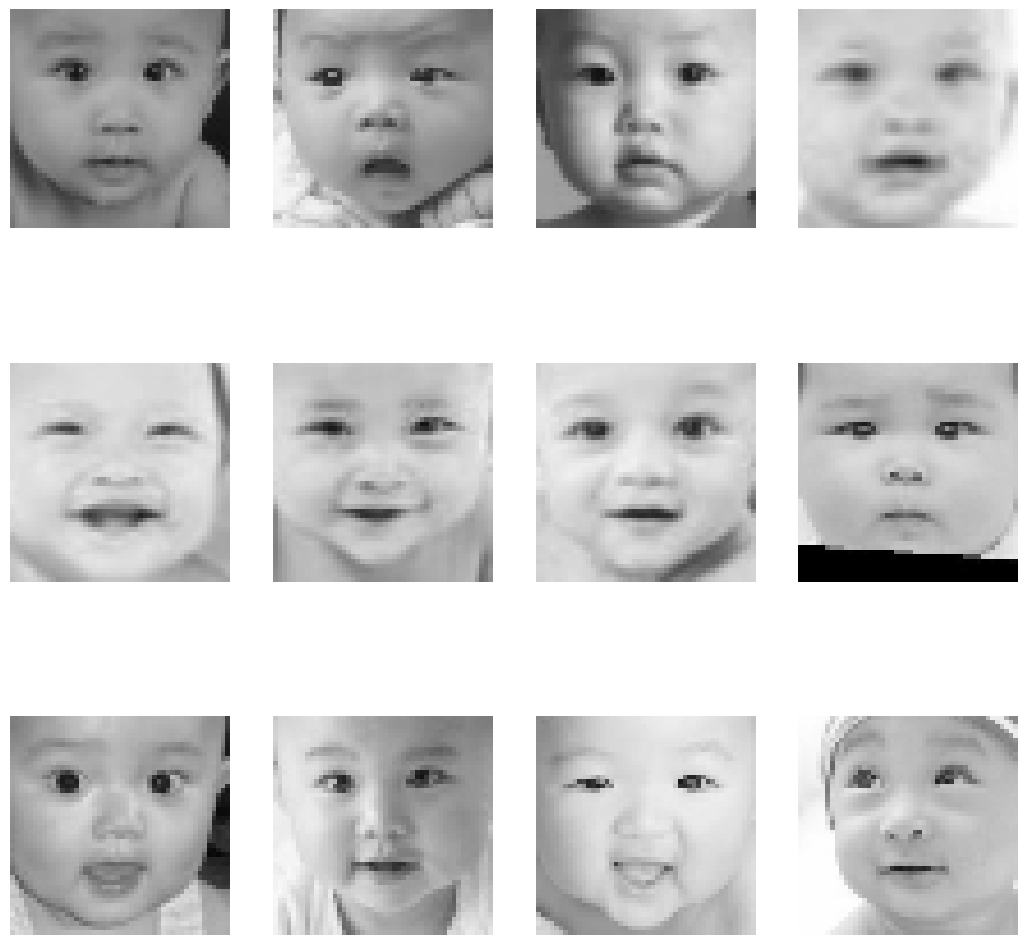

In [55]:
plt.figure(figsize = (13, 13))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    im = cv2.cvtColor(X[i].astype('uint8'), cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.axis('off')

In [10]:
batch_size = 128
latent_dim = 10
epochs = 10
learning_rate = 1e-3

In [11]:
X_scaled = X / 255.0

In [12]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [13]:
class MyDataset(Dataset):
    def __init__(self, images, transform = None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img

In [14]:
dataset = MyDataset(X_scaled, transform = transform)

In [15]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [16]:
for batch in dataloader:
    print(batch.min().item(), batch.max().item())
    break

0.0 0.996078431372549


In [134]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(48 * 48, 400)
        self.fc2_mu = nn.Linear(400, latent_dim)
        self.fc2_logvar = nn.Linear(400, latent_dim)

    def forward(self, x):
        x = x.view(-1, 48 * 48)
        h1 = F.relu(self.fc1(x))
        mu = self.fc2_mu(h1)
        logvar = self.fc2_logvar(h1)
        return mu, logvar

In [135]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, 48 * 48)

    def forward(self, z):
        h1 = F.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h1))
        return x_recon.view(-1, 1, 48, 48)

In [140]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [141]:
model = VAE()

In [142]:
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [143]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_idx, data in enumerate(dataloader):
        data = data.float()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        recon_loss = F.binary_cross_entropy(recon_batch, data, reduction = 'sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1} / {epochs}, Loss: {total_loss / len(dataloader.dataset):.4f}')

Epoch 1 / 10, Loss: 1444.0711
Epoch 2 / 10, Loss: 1415.1264
Epoch 3 / 10, Loss: 1411.3286
Epoch 4 / 10, Loss: 1409.7407
Epoch 5 / 10, Loss: 1408.9320
Epoch 6 / 10, Loss: 1408.0822
Epoch 7 / 10, Loss: 1407.4405
Epoch 8 / 10, Loss: 1407.0567
Epoch 9 / 10, Loss: 1406.6148
Epoch 10 / 10, Loss: 1406.3939


In [144]:
with torch.no_grad():
    z = torch.randn(64, latent_dim)
    generated = model.decoder(z)

In [145]:
grid = torchvision.utils.make_grid(generated, nrow = 8, padding = 2, normalize = True)

In [146]:
npimg = grid.numpy()

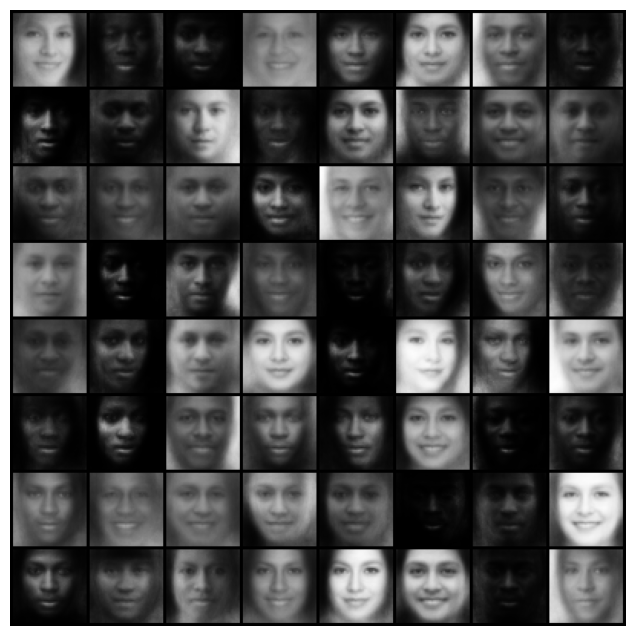

In [147]:
plt.figure(figsize = (8, 8))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')
plt.show()

In [24]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.flatten_dim = 256 * 3 * 3
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self.flatten_dim)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [25]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, 256 * 3 * 3)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.deconv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 256, 3, 3)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x_recon = torch.sigmoid(self.deconv4(x))
        return x_recon

In [26]:
class VAE2(nn.Module):
    def __init__(self):
        super().__init__()
        self.convencoder = ConvEncoder(latent_dim)
        self.convdecoder = ConvDecoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.convencoder(x)
        z = self.reparameterize(mu, logvar)
        return self.convdecoder(z), mu, logvar

In [27]:
model2 = VAE2()

In [30]:
optimizer = optim.Adam(model2.parameters(), lr = learning_rate)

In [31]:
for epoch in range(epochs):
    model2.train()
    total_loss = 0
    for batch_idx, data in enumerate(dataloader):
        data = data.float()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model2(data)
        recon_loss = F.binary_cross_entropy(recon_batch, data, reduction = 'sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1} / {epochs}, Loss: {total_loss / len(dataloader.dataset):.4f}')

Epoch 1 / 10, Loss: 1432.3635
Epoch 2 / 10, Loss: 1408.5267
Epoch 3 / 10, Loss: 1406.4243
Epoch 4 / 10, Loss: 1405.3636
Epoch 5 / 10, Loss: 1404.6594
Epoch 6 / 10, Loss: 1403.9262
Epoch 7 / 10, Loss: 1403.5432
Epoch 8 / 10, Loss: 1403.0107
Epoch 9 / 10, Loss: 1402.6323
Epoch 10 / 10, Loss: 1402.2455


In [34]:
with torch.no_grad():
    z = torch.randn(64, latent_dim)
    generated = model2.convdecoder(z)

In [35]:
grid = torchvision.utils.make_grid(generated, nrow = 8, padding = 2, normalize = True)

In [36]:
npimg = grid.numpy()

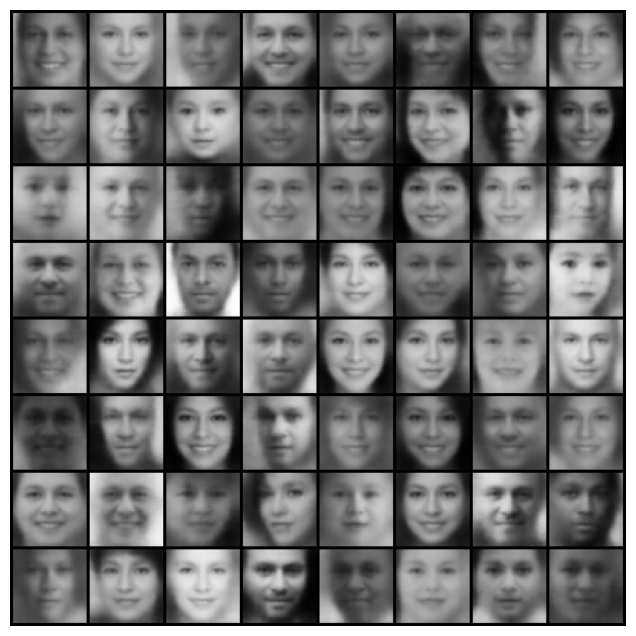

In [37]:
plt.figure(figsize = (8, 8))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')
plt.show()